# Tutorial followed from https://blog.paperspace.com/creating-custom-environments-openai-gym/

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import PIL.Image as Image
import gym
import random
import jdc

from gym import Env, spaces
import time 
font = cv2.FONT_HERSHEY_COMPLEX_SMALL

Error: Kernel is dead

The environment that we are creating is basically a game that is heavily inspired by the Dino Run game, the one which you play in Google Chrome if you are disconnected from the Internet. There is a dinosaur, and you have to jump over cacti and avoid hitting birds. The distance you cover is representative of the reward you end up getting.

In our game, instead of a dinosaur, our agent is going to be a Chopper pilot.

1. The chopper has to cover as much distance as possible to get the maximum reward. There will be birds  that the chopper has to avoid.
2. The episode terminates in case of a bird strike. The episode can also terminate if the Chopper runs out of fuel.
3. Just like birds, there are floating fuel tanks (yes, no points for being close to reality, I know!) which the Chopper can collect to refuel the chopper to its full capacity (which is fixed at 1000 L).

The very first consideration while designing an environment is to decide what sort of observation space and action space we will be using.

1. The observation space can be either continuous or discrete. An example of a discrete action space is that of a grid-world where the observation space is defined by cells, and the agent could be inside one of those cells. An example of a continuous action space is one where the position of the agent is described by real-valued coordinates.

2. The action space can be either continuous or discrete as well. An example of a discrete space is one where each action corresponds to the particular behavior of the agent, but that behavior cannot be quantified. An example of this is Mario Bros, where each action would lead to moving left, right, jumping, etc. Your actions can't quantify the behavior being produced, i.e. you can jump but not jump high, higher, or lower. However, in a game like Angry Birds, you decide how much to stretch the slingshot (you quantify it).

In [ ]:
class ChopperScape(Env):
    def __init__(self):
        super(ChopperScape, self).__init__()
        

        # 2D observation space
        self.observation_shape = (600,800,3)
        # Box is used cuz continuous
        self.observation_space = spaces.Box(low = np.zeros(self.observation_shape),
                                            high = np.ones(self.observation_shape),
                                            dtype = np.float32)
        
        # define an action space ranging from 0 to 4
        self.action_space = spaces.Discrete(6,)

        # canvas to render the environment images upon
        self.canvas = np.ones(self.observation_shape) * 1

        # define elements present inside the environment
        self.elements = []

        # max fuel
        self.max_fuel = 1000

        # permissible area of helicopter to be
        self.y_min = int (self.observation_shape[0] * 0.1)
        self.x_min = 0
        self.y_max = int (self.observation_shape[0] * 0.9)
        self.x_max = self.observation_shape[1]


# Elements of the Environment

Once we have determined the action space and the observation space, we need to finalize what would be the elements of our environment. In our game, we have three distinct elements: the Chopper, Flying Birds, and and Floating Fuel Stations. We will be implementing all of these as separate classes that inherit from a common base class called Point.

# Point Base Class
The Point class is used to define any arbitrary point on our observation image. We define this class with the following attributes:

 - (x,y): Position of the point on the image.
 - (x_min, x_max, y_min, y_max): Permissible coordinates for the point. If we try to set the position of the point outside these limits, the position values are clamped to these limits.
 - name: Name of the point.

We define the following member functions for this class.

 - get_position: Get the coordinates of the point.
 - set_position: Set the coordinates of the point to a certain value.
 - move: Move the points by certain value.

In [ ]:
class Point(object):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        self.x = 0
        self.y = 0
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.name = name
    
    def set_position(self, x, y):
        self.x = self.clamp(x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(y, self.y_min, self.y_max - self.icon_h)

    def get_position(self):
        return (self.x, self.y)
    
    def move(self, del_x, del_y):
        self.x += del_x
        self.y += del_y

        self.x = self.clamp(self.x, self.x_min, self.x_max - self.icon_w)
        self.y = self.clamp(self.y, self.y_min, self.y_max - self.icon_h)

    def clamp(self, n, minn, maxn):
        return max(min(n,maxn), minn)

Now we define the classes Chopper, Bird and Fuel. These classes are derived from the Point class, and introduce a set of new attributes:

 - icon: Icon of the point that will display on the  observation image when the game is rendered.
 - (icon_w, icon_h): Dimensions of the icon.

In [ ]:
class Chopper(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Chopper, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("chopper.png") / 255.0
        self.icon_w = 64
        self.icon_h = 64
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))

class Bird(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Bird, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("bird.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
        
class Fuel(Point):
    def __init__(self, name, x_max, x_min, y_max, y_min):
        super(Fuel, self).__init__(name, x_max, x_min, y_max, y_min)
        self.icon = cv2.imread("fuel.png") / 255.0
        self.icon_w = 32
        self.icon_h = 32
        self.icon = cv2.resize(self.icon, (self.icon_h, self.icon_w))
        

# Back to the ChopperScape Class

Recall from Part 1 that any gym Env class has two important functions:

1. reset: Resets the environment to its initial state and returns the initial observation.
2. step : Executes a step in the environment by applying an action. Returns the new observation, reward, completion status, and other info.

In this section, we will be implementing the reset and step functions of our environment along with many other helper functions. We begin with reset function.

# Reset Function

When we reset our environment, we need to reset all the state-based variables in our environment. These include things like fuel consumed, episodic return, and the elements present inside the environment.

In our case, when we reset our environment, we have nothing but the Chopper in the initial state. We initialize our chopper randomly in an area in the top-left of our image. This area is 5-10 percent of the image width and 15-20 percent of the image height.

We also define a helper function called draw_elements_on_canvas that basically places the icons of each of the elements present in the game at their respective positions in the observation image. If the position is beyond the permissible range, then the icons are placed on the range boundaries. We also print important information such as the remaining fuel.

We finally return the canvas on which the elements have been placed as the observation.

In [ ]:
%%add_to ChopperScape

def draw_elements_on_canvas(self):
    # init the canvas
    self.canvas = np.ones(self.observation_shape) * 1

    # draw the helicopter on canvas
    for elem in self.elements:
        elem_shape = elem.icon.shape
        x,y = elem.x, elem.y
        self.canvas[y : y + elem_shape[1], x : x + elem_shape[0]] = elem.icon

    text = 'Fuel Left: {} | Rewards: {}'.format(self.fuel_left, self.ep_return)

    # put info on canvas
    self.canvas = cv2.putText(self.canvas, text, (10,20), font,
                            0.8, (0,0,0), 1, cv2.LINE_AA)

def reset(self):
    # reset fuel
    self.fuel_left = self.max_fuel

    # reset reward
    self.ep_return = 0

    # number of birds
    self.bird_count = 0
    self.fuel_count = 0

    # init chopper
    x = random.randrange(int(self.observation_shape[0]*0.05), int(self.observation_shape[0]*0.10))
    y = random.randrange(int(self.observation_shape[1]*0.15), int(self.observation_shape[1]*0.20))

    # initialize the chopper
    self.chopper = Chopper("chopper", self.x_max, self.x_min, self.y_max, self.y_min)
    self.chopper.set_position(x,y)

    # initialize the elements
    self.elements = [self.chopper]

    # reset the canvas
    self.canvas = np.ones(self.observation_shape) * 1

    # draw the elements on canvas
    self.draw_elements_on_canvas()

    # return the observation
    return self.canvas





## Initial Observation

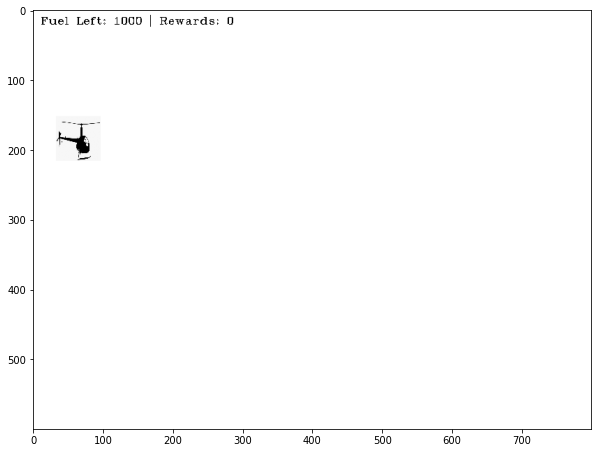

In [ ]:
env = ChopperScape()
obs = env.reset()
plt.figure(figsize=(10,15))
plt.imshow(obs)

Since our observation is the same as the gameplay screen of the game, our render function shall return our observation too. We build functionality for two modes, one human which would render the game in a pop-up window, while rgb_array returns it as a pixel array.

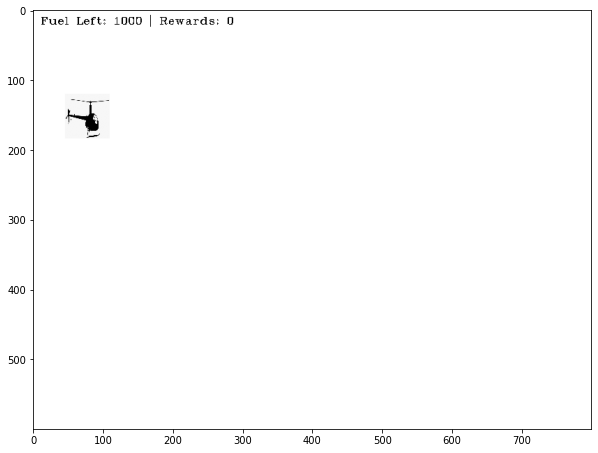

In [ ]:
%%add_to ChopperScape

def render(self, mode="human"):
    assert mode in ["human", "rgb_array"], "Invalid mode, must be either \"human\" or \"rgb_array\""
    if mode == "human":
        cv2.imshow("Game", self.canvas)
        cv2.waitKey(10)
    
    elif mode == "rgb_array":
        return self.canvas

def close(self):
    cv2.destroyAllWindows()

env = ChopperScape()
obs = env.reset()
screen = env.render(mode="rgb_array")
plt.figure(figsize=(10,15))
plt.imshow(screen)

# Step Function

Now that we have the reset function out of the way, we begin work on implementing the step function, which will contain the code to transition our environment from one state to the next given an action. In many ways, this section is the proverbial meat of our environment, and this is where most of the planning goes.

We first need to enlist things that need to happen in one transition step of the environment. This can be basically broken down into two parts:

1. Applying actions to our agent.
2. Everything else that happens in the environments, such as behaviour of the non-RL actors (e.g. birds and floating gas stations).

So let's first focus on (1). We provide actions to the game that will control what our chopper does. We basically have 5 actions, which are move right, left, down, up, or do nothing, denoted by 0, 1, 2, 3, and 4, respectively.  

We define a member function called get_action_meanings() that will tell us what integer each action is mapped to for our reference.



In [ ]:
%%add_to ChopperScape

def get_action_meanings(self):
    return {0: "Right", 1: "Left", 2: "Down", 3: "Up", 4: "Do Nothing"}


Now that we have taken care of applying the action to the chopper, we focus on the other elements of the environment:

 - Birds spawn randomly from the right edge of the screen with a probability of 1% (i.e. a bird is likely to appear on the right edge once every hundred frames). The bird moves 5 coordinate points every frame to the left. If they hit the Chopper the game ends. Otherwise, they disappear from the game once they reach the left edge.
 - Fuel tanks spawn randomly from the bottom edge of the screen with a probability of 1 % (i.e. a fuel tank is likely to appear on the bottom edge once every hundred frames). The bird moves 5 co-ordinates up every frame. If they hit the Chopper, the Chopper is fuelled to its full capacity. Otherwise, they disappear from the game once they reach the top edge.

In order to implement the features outlined above, we need to implement a helper function that helps us determine whether two Point objects (such as a Chopper/Bird, Chopper/Fuel Tank) have collided or not. How do we define a collision? We say that two points have collided when the distance between the coordinates of their centers is less than half of the sum of their dimensions. We call this function has_collided

In [ ]:
%%add_to ChopperScape

def has_collided(self, elem1, elem2):
    x_col = False
    y_col = False

    elem1_x, elem1_y = elem1.get_position()
    elem2_x, elem2_y = elem2.get_position()

    if 2 * abs(elem1_x - elem2_x) <= (elem1.icon_w + elem2.icon_w):
        x_col = True

    if 2 * abs(elem1_y - elem2_y) <= (elem1.icon_h + elem2.icon_h):
        y_xol = True
    
    if x_col and y_col:
        return True
    
    return False

Apart from this, we have to do some book-keeping. The reward for each step is 1, therefore, the episodic return counter is updated by 1 every episode. If there is a collision, the reward is -10 and the episode terminates. The fuel counter is reduced by 1 at every step.

Finally, we implement our step function. I've wrote extensive comments to guide you through it.

In [ ]:
%%add_to ChopperScape

def step(self, action):
    done = False

    assert self.action_space.contains(action), "Invalid Action"

    self.fuel_left -= 1

    reward = 1

    if action == 0:
        self.chopper.move(0,5)
    elif action == 1:
        self.chopper.move(0,-5)
    elif action == 2:
        self.chopper.move(5,0)
    elif action == 3:
        self.chopper.move(-5,0)
    elif action == 4:
        self.chopper.move(0,0)

    # spawn a bird with 0.01 prob
    if random.random() < 0.01:

        spawned_bird = Bird("bird_{}".format(self.bird_count), self.x_max, self.x_min, self.y_max, self.y_min)
        self.fuel_count += 1

        # Compute the x,y co-ordinates of the position from where the bird has to be spawned
        # Horizontally, the position is on the right edge and vertically, the height is randomly 
        # sampled from the set of permissible values
        bird_x = self.x_max
        bird_y = random.randrange(self.y_min, self.y_max)
        spawned_bird.set_position(bird_x, bird_y)

        self.elements.append(spawned_bird)

    # spawn a fuel tank
    if random.random() < 0.01:
        spawned_fuel = Fuel("fuel_{}".format(self.fuel_count), self.x_max, self.x_min, self.y_max, self.y_min)
        self.fuel_count += 1

        # Compute the x,y co-ordinates of the position from where the fuel tank has to be spawned
        # Horizontally, the position is randomly chosen from the list of permissible values and 
        # vertically, the position is on the bottom edge
        fuel_x = random.randrange(self.x_min, self.x_max)
        fuel_y = self.y_max
        spawned_fuel.set_position(fuel_x, fuel_y)

        self.elements.append(spawned_fuel)
    
    for elem in self.elements:
        if isinstance(elem, Bird):
            # If the bird has reached the left edge, remove it from the Env
            if elem.get_position()[0] <= self.x_min:
                self.elements.remove(elem)
            else:
                # Move the bird left by 5 pts.
                elem.move(-5,0)
            
            # if bird collides
            if self.has_collided(self.chopper, elem):
                # conclude the episode and remove chopper
                done = True
                reward -= 10
                self.elements.remove(self.chopper)
        
        if isinstance(elem, Fuel):
            # if the fuel tank has reached top, remove it
            if elem.get_position()[1] <= self.y_min:
                self.elements.remove(elem)
            else:
                elem.move(0,-5)
            
            # if fuel collides with chopper
            if self.has_collided(self.chopper, elem):
                # remove fuel tank
                self.elements.remove(elem)

                # fill tank
                self.fuel_tank = self.max_fuel
    
    self.ep_return += 1

    self.draw_elements_on_canvas()

    if self.fuel_left == 0:
        done = True
    
    return self.canvas, reward, done, []


In [ ]:
from IPython import display

env = ChopperScape()
obs = env.reset()

while True:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    env.render()

    if done == True:
        break

env.close()

C:\Users\Abhinav\anaconda3\envs\pytorch_env\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


TypeError: super(type, obj): obj must be an instance or subtype of type